# Load local dataset

In [1]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils

importlib.reload(utils)

<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

In [2]:
# Load specific dataset:

import sys,os
sys.path.append(os.getcwd())


from PrepareDatasets import DATASETS
import my_utils
import dataset_utils


print(DATASETS.keys())
"""
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
    'NCI1': NCI1,
    'DD': DD,
    "MUTAG": Mutag,
    'CSL': CSL
"""

data_names = ['PROTEINS']
data_names = ['DD']
data_names = ['ENZYMES']
data_names = ['NCI1']
data_names = ['IMDB-MULTI']
data_names = ['REDDIT-BINARY']
data_names = ['CIFAR10']
data_names = ['ogbg_molhiv']


# NOTE:new kernel:
data_names = ['MUTAG']
data_names = ['DD', 'PROTEINS', 'ENZYMES']

data_names = ['ogbg_moltox21','ogbg-molbace']




datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

dict_keys(['REDDIT-BINARY', 'REDDIT-MULTI-5K', 'COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'AIDS', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL', 'CIFAR10', 'MNIST', 'PPI', 'hiv', 'bace', 'bbpb', 'ogbg_molhiv', 'ogbg_ppa', 'PTC', 'QM9', 'ogbg_moltox21', 'ogbg-molbbbp', 'ogbg-molbace'])
loaded dataset, name: ogbg_moltox21
processed_dir:  DATA/ogbg-moltox21/processed
load dataset !
!!!! _dim_target:  12
dataset len:  7831
loaded dataset, name: ogbg-molbace
processed_dir:  DATA/ogbg-molbace/processed
load dataset !
!!!! _dim_target:  1
dataset len:  1513


# TODO: load synthetic datasets:


In [ ]:



cc_dataset = DATASETS['syn_cc']()

In [3]:
def get_each_folder(data_name, fold_id, batch_size=1):
    
    fold_test = datasets_obj[data_name].get_test_fold(fold_id, batch_size=batch_size, shuffle=True).dataset
    fold_train, fold_val = datasets_obj[data_name].get_model_selection_fold(fold_id, inner_idx=None,
                                                                          batch_size=batch_size, shuffle=True)
    fold_train = fold_train.dataset
    fold_val = fold_val.dataset
    
    # train_G = [pyg_utils.to_networkx(d, node_attrs=['x']) for d in fold_train.get_subset()]
    # test_G = [pyg_utils.to_networkx(d, node_attrs=['x']) for d in fold_test.get_subset()]
    # print('x: ',train_G[0].nodes[0]['x'])
    
    train_adjs, test_adjs = [], []
    train_y, test_y = [], []
    
    def node_fea_to_dict(node_fea):
        res = {}
        for i in range(node_fea.shape[0]):
            res[i] = node_fea[i]
        return res
    print('train len:', len(fold_train))
    print('test len:', len(fold_test))
    print('total len: ', len(datasets_obj[data_name].dataset))
    
    
    if hasattr(fold_train, "get_subset"):
        for d in fold_train.get_subset():

            train_y.append(d.y.item())
            train_adjs.append([d.to_numpy_array()])

        for d in fold_test.get_subset():
            test_y.append(d.y.item())
            test_adjs.append([d.to_numpy_array()])
            
    else:
        train_adjs = datasets_obj[data_name].get_dense_adjs(fold_train)
        test_adjs = datasets_obj[data_name].get_dense_adjs(fold_test)
        
        for d in fold_train:
            train_y.append(d.y)
        # is_labeled = data.y == data.y
        for d in fold_test:
            test_y.append(d.y)
            
        train_y = torch.cat(train_y, dim=0)
        test_y = torch.cat(test_y, dim=0)
        
        print('train y shape:', train_y.shape)
        print('test y shape:', test_y.shape)
    return train_adjs, test_adjs, train_y, test_y
    # do not use val for kernel methods.
#     for d in fold.dataset.get_subset():

In [4]:
# Transform from networkx
from grakel.utils import graph_from_networkx

# Multilabel Classification Example:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Configuration options
num_samples_total = 10000
cluster_centers = [(5,5), (3,3)]
num_classes = len(cluster_centers)

# Generate data
X, classes = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.30)
colors = np.random.randint(0, 2, size=len(classes))

# Combine training labels
y = np.vstack((classes, colors)).T

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create the SVM
svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
not_label = y_train == y_train
multilabel_classifier = multilabel_classifier.fit(X_train[not_label], y_train[not_label])

# Get predictions for test data
y_test_pred = multilabel_classifier.predict(X_test)

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_test_pred)

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1 (type)')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2 (color)')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[5.23549671 4.79153166 3.05884285 ... 5.22527669 4.78327541 4.77065997].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [14]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

from grakel.datasets import fetch_dataset
from grakel.kernels import ShortestPath
import numpy as np
from grakel.kernels import WeisfeilerLehman,SubgraphMatching
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from grakel import Graph
from grakel import utils as g_utils

import networkx as nx
# Loads the MUTAG dataset



# Define the Weisfeiler-Lehman kernel

def train_with_wl_kernel(wl_kernel, train_adj_matrices, test_adj_matrices, train_labels, test_labels):
    y_train = train_labels
    y_test = test_labels
    
    
    def transform_to_gr_graphs(adjs):
        nx_gs = []
        all_node_labels = []
        for m in adjs:
            if isinstance(m, list) or len(m.shape) > 2:
                nx_g = nx.from_numpy_array(m[0])
                N = m[0].shape[0]
            else:
                nx_g = nx.from_numpy_array(m)
                N = m.shape[0]
                
            node_labels = {i:0 for i in range(N)}
            nx_gs.append(nx_g)
            all_node_labels.append(node_labels)
        
        gr_graphs =  [g for g in g_utils.graph_from_networkx(nx_gs, as_Graph=True)]
        
        for i, g in enumerate(gr_graphs):
            g.node_labels = all_node_labels[i]
            
        return gr_graphs
    
    
    train_graphs = transform_to_gr_graphs(train_adj_matrices)
    test_graphs = transform_to_gr_graphs(test_adj_matrices)
    
    wl_kernel.fit(train_graphs)

    # Transform the graphs using the Weisfeiler-Lehman kernel
    X_train = wl_kernel.transform([graph for graph in train_graphs])
    X_test = wl_kernel.transform([graph for graph in test_graphs])

    # Train an SVM classifier on the transformed training data
    svm = SVC()
    
    if y_train.dim() > 1 and y_train.shape[-1] > 1:
        multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

        # Fit the data to the Multilabel classifier
        not_label = y_train == y_train
        
        multilabel_classifier = multilabel_classifier.fit(X_train[not_label], y_train[not_label])

        # Get predictions for test data
        y_test_pred = multilabel_classifier.predict(X_test)
    else:
        svm.fit(X_train, y_train)
        # Predict labels on the validation and test data using the trained SVM classifier
        y_test_pred = svm.predict(X_test)

    # Calculate the accuracy of the SVM classifier on the validation and test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    return test_accuracy



# MUTAG = fetch_dataset("MUTAG", verbose=False)
# G, y = MUTAG.data, MUTAG.target
# print('G10:', G[0])

def train_with_kernel(gk, dataset_name):
    res=[]
    for i in range(10):
        G_train, G_test, y_train, y_test = get_each_folder(dataset_name,i)
        
        # G_train = [g for g in graph_from_networkx(G_train,node_labels_tag='x')]
        # G_test = [g for g in graph_from_networkx(G_test,node_labels_tag='x')]
        # print('G_train 10:',G_train[:10])
        
        # G_train, G_test, y_train, y_test = train_test_split(G_train, y_train, test_size=0.1)
        # Uses the shortest path kernel to generate the kernel matrices
        if isinstance(gk, WeisfeilerLehman) or isinstance(gk, SubgraphMatching):
            res.append(train_with_wl_kernel(gk,  G_train, G_test, y_train, y_test))
        else:
            K_train = gk.fit_transform(G_train)
            K_test = gk.transform(G_test)

            # Uses the SVM classifier to perform classification
            clf = SVC(kernel="precomputed")
            clf.fit(K_train, y_train)
            y_pred = clf.predict(K_test)

            # Computes and prints the classification accuracy
            acc = accuracy_score(y_test, y_pred)
            res.append(acc)
            # print("Accuracy:", str(round(acc*100, 2)) + "%")
        
    res = np.array(res)
    print(f'Acc, mean: {round(np.mean(res)*100, 4)}, std: {round(100*np.std(res),4)}')

In [59]:
# MUTAG

from grakel.kernels import ShortestPath, WeisfeilerLehman, SubgraphMatching



print('kernel on:', data_names[0])

gks = [ShortestPath(normalize=True, with_labels=False),
      WeisfeilerLehman(n_iter=5),
      SubgraphMatching(normalize=True)]

train_with_kernel(WeisfeilerLehman(n_iter=5), data_names[0])
train_with_kernel(SubgraphMatching(), data_names[0])
train_with_kernel(ShortestPath(normalize=True, with_labels=False), data_names[0])
    

kernel on: MUTAG
Acc, mean: 85.117, std: 8.0719
Acc, mean: 85.117, std: 8.0719
Acc, mean: 78.7719, std: 6.575


In [15]:
# data_names = ['ogbg_moltox21','ogbg-molbace']

from grakel.kernels import ShortestPath, WeisfeilerLehman, SubgraphMatching

for dname in data_names:
    print('kernel on:', dname)
    train_with_kernel(WeisfeilerLehman(n_iter=10), dname)
    train_with_kernel(SubgraphMatching(), dname)
    train_with_kernel(ShortestPath(normalize=True, with_labels=False), dname)

kernel on: ogbg_moltox21
train len: 6264
test len: 784
total len:  7831
train y shape: torch.Size([6264, 12])
test y shape: torch.Size([784, 12])


IndexError: boolean index did not match indexed array along dimension 1; dimension is 6264 but corresponding boolean dimension is 12

In [6]:
# run:

from grakel.kernels import ShortestPath, WeisfeilerLehman, SubgraphMatching


for name in data_names:
    print('kernel on:', name)
    gks = [ShortestPath(normalize=True, with_labels=False),
        WeisfeilerLehman(n_iter=5),
        SubgraphMatching(normalize=True)]

    train_with_kernel(WeisfeilerLehman(n_iter=5), data_names[0])
    train_with_kernel(SubgraphMatching(), data_names[0])
    train_with_kernel(ShortestPath(normalize=True, with_labels=False), data_names[0])
    

kernel on: DD


# SVM for $|V|+\alpha|E|$

In [7]:
from dataset_utils.node_feature_utils import graph_invariant

def train_simple_svm(kernel_name, dataset_name, folds_num=10):
    res = []
    auc = []
    for i in range(folds_num):
        train_adjs, test_adjs, train_y, test_y= get_each_folder(dataset_name, i)
        # NOTE: adj -> graph_features
        
        train_x = [graph_invariant(adj=adj[0]) for adj in train_adjs]
        test_x = [graph_invariant(adj=adj[0]) for adj in test_adjs]
        Classifier = SVC(kernel=kernel_name)
        Classifier.fit(train_x, train_y)
        y_pred = Classifier.predict(test_x)
        # Computes and prints the classification accuracy
        acc = accuracy_score(test_y, y_pred)
        rocauc = roc_auc_score(test_y, y_pred)
        res.append(acc)
        auc.append(rocauc)
        # print("Accuracy:", str(round(acc*100, 2)) + "%")
        
    res = np.array(res)
    auc = np.array(auc)
    
    print(f'Acc, mean: {round(np.mean(res)*100, 4)}, std: {round(100*np.std(res),4)}')
    print(f'ROCAUC, mean: {round(np.mean(auc)*100, 4)}, std: {round(100*np.std(auc),4)}')





In [28]:
# MUTAG:
print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_simple_svm(kr)

Acc, mean: 85.117, std: 8.0719
Acc, mean: 82.9532, std: 7.7978
Acc, mean: 86.2281, std: 8.5031
Acc, mean: 66.4912, std: 2.2807


In [7]:
# Proteins:

print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf', 'sigmoid']:
    print('kernel used:', kr)
    train_simple_svm(kr)

kernel on: PROTEINS
Acc, mean: 69.1739, std: 4.5649
Acc, mean: 59.5681, std: 0.1659
Acc, mean: 72.5, std: 2.5759
Acc, mean: 59.1144, std: 5.4115


In [7]:
# DD:

print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf', 'sigmoid']:
    print('kernel used:', kr)
    train_simple_svm(kr)

kernel on: DD
kernel used: linear
Acc, mean: 75.5556, std: 2.3243
kernel used: poly
Acc, mean: 65.8743, std: 2.5075
kernel used: rbf
Acc, mean: 76.0648, std: 3.2092
kernel used: sigmoid
Acc, mean: 62.3801, std: 12.4925


In [14]:
# ENZYMES:

print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_simple_svm(kr)

kernel on: ENZYMES
Acc, mean: 22.3333, std: 4.6068
Acc, mean: 20.5, std: 3.5785
Acc, mean: 22.3333, std: 3.8152
Acc, mean: 13.3333, std: 4.5947


In [11]:
# NCI1:

print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_simple_svm(kr)

kernel on: NCI1
Acc, mean: 62.5061, std: 1.8026
Acc, mean: 59.927, std: 1.4106
Acc, mean: 62.5061, std: 1.7927
Acc, mean: 37.7859, std: 2.1462


: 

In [8]:
# COLLAB:

print('kernel on:', data_names[0])
for kr in ['linear', 'poly', 'rbf']:
    train_simple_svm(kr)

kernel on: COLLAB
Acc, mean: 53.88, std: 1.1737
Acc, mean: 60.82, std: 0.6161
Acc, mean: 61.66, std: 1.1351


In [9]:
# IMDB-M:

print('kernel on:', data_names[0])
for kr in ['poly', 'rbf']:
    train_simple_svm(kr, data_names[0])

kernel on: IMDB-MULTI
Acc, mean: 33.4, std: 0.8138
Acc, mean: 40.3333, std: 3.7977


In [6]:
# CIFAR10

print('kernel on:', data_names[0])
for kr in ['poly', 'rbf']:
    train_simple_svm(kr, data_names[0], folds_num=1)

kernel on: CIFAR10
idxs keys: dict_keys(['train', 'validation'])


Acc, mean: 12.31, std: 0.0
idxs keys: dict_keys(['train', 'validation'])
Acc, mean: 14.62, std: 0.0


In [7]:
# HIV
print('kernel on:', data_names[0])
for kr in ['poly', 'rbf']:
    train_simple_svm(kr, data_names[0], folds_num=1)

kernel on: ogbg_molhiv
idxs keys: dict_keys(['train', 'validation'])
Acc, mean: 96.8393, std: 0.0
ROCAUC, mean: 50.0, std: 0.0
idxs keys: dict_keys(['train', 'validation'])
Acc, mean: 96.8393, std: 0.0
ROCAUC, mean: 50.0, std: 0.0


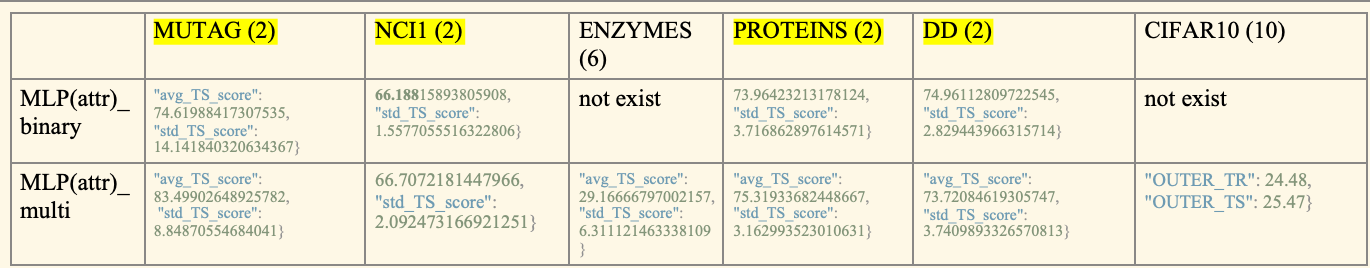

In [8]:
# REDDIT-B
print('kernel on:', data_names[0])
for kr in ['rbf']:
    train_simple_svm(kr, data_names[0], folds_num=1)

kernel on: REDDIT-BINARY
idxs keys: dict_keys(['train', 'validation'])
Acc, mean: 79.0, std: 0.0
ROCAUC, mean: 79.0, std: 0.0


In [9]:
# REDDIT-B
print('kernel on:', data_names[0])
for kr in ['poly']:
    train_simple_svm(kr, data_names[0], folds_num=1)

kernel on: REDDIT-BINARY
idxs keys: dict_keys(['train', 'validation'])
Acc, mean: 61.0, std: 0.0
ROCAUC, mean: 61.0, std: 0.0
